In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

ModuleNotFoundError: No module named 'google.colab'

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [10]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [11]:
# Load the raw CIFAR-10 data.
cifar10_dir = r"C:\Users\Kraveta\Desktop\stanford\assignment1\cs231n\datasets\cifar-10-batches-py"

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


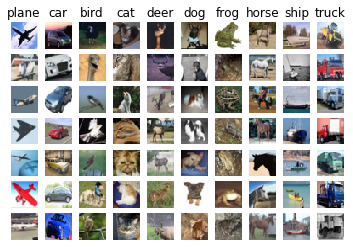

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [12]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [13]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


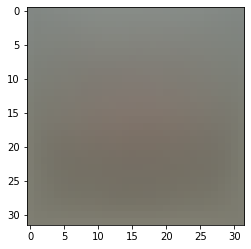

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [14]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [438]:
import importlib
import cs231n
importlib.reload(cs231n)

<module 'cs231n' from 'C:\\Users\\Kraveta\\Desktop\\stanford\\assignment1\\cs231n\\__init__.py'>

In [16]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.362222


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [145]:
def grad_check_sparse(f, x, analytic_grad, h=1e-5):
    for i in range(analytic_grad.shape[0]):
        for j in range(analytic_grad.shape[1]):
            ix = (i,j)

            oldval = x[ix]
            print(oldval)
            x[ix] = oldval + h  # increment by h
            fxph = f(x)  # evaluate f(x + h)
            x[ix] = oldval - h  # increment by h
            fxmh = f(x)  # evaluate f(x - h)
            x[ix] = oldval  # reset

            grad_numerical = (fxph - fxmh) / (2 * h)
            grad_analytic = analytic_grad[ix]
            rel_error = abs(grad_numerical - grad_analytic) / (
                abs(grad_numerical) + abs(grad_analytic)
            )
            print(
                "numerical: %f analytic: %f, relative error: %e"
                % (grad_numerical, grad_analytic, rel_error)
            )

grad_check_sparse(f, W_toy, grad)

0.2
numerical: -112.000000 analytic: -112.000000, relative error: 1.892892e-11
1.5
numerical: 56.000000 analytic: 56.000000, relative error: 6.447604e-12
0.0
numerical: 56.000000 analytic: 56.000000, relative error: 4.430545e-11
-0.5
numerical: -462.000000 analytic: -462.000000, relative error: 7.394135e-12
1.3
numerical: 231.000000 analytic: 231.000000, relative error: 4.909635e-12
0.25
numerical: 231.000000 analytic: 231.000000, relative error: 4.909635e-12
0.1
numerical: -48.000000 analytic: -48.000000, relative error: 7.814083e-11
2.1
numerical: 24.000000 analytic: 24.000000, relative error: 7.814083e-11
0.2
numerical: 24.000000 analytic: 24.000000, relative error: 4.028296e-11
2.0
numerical: -4.000000 analytic: -4.000000, relative error: 1.587068e-10
0.0
numerical: 2.000000 analytic: 2.000000, relative error: 1.587068e-10
-0.3
numerical: 2.000000 analytic: 2.000000, relative error: 1.262379e-09


In [64]:
W_toy = np.array([[0.2, -0.5, 0.1, 2.0],[1.5, 1.3, 2.1, 0.0],
                  [0, 0.25, 0.2, -0.3]]).transpose()
X_toy =  np.array([[56, 231, 24, 2]])
Y_toy = np.array([0])

In [132]:
f = lambda w: cs231n.classifiers.linear_svm.svm_loss_naive(w, X_toy, Y_toy, 0.0)[0]
loss, grad = cs231n.classifiers.linear_svm.svm_loss_naive(W_toy, X_toy, Y_toy, 0.0)
grad_check_sparse(f, W_toy, grad)

numerical: -112.000000 analytic: -112.000000, relative error: 1.892892e-11
numerical: 56.000000 analytic: 56.000000, relative error: 6.447604e-12
numerical: 56.000000 analytic: 56.000000, relative error: 4.430545e-11
numerical: -462.000000 analytic: -462.000000, relative error: 7.394135e-12
numerical: 231.000000 analytic: 231.000000, relative error: 4.909635e-12
numerical: 231.000000 analytic: 231.000000, relative error: 4.909635e-12
numerical: -48.000000 analytic: -48.000000, relative error: 7.814083e-11
numerical: 24.000000 analytic: 24.000000, relative error: 7.814083e-11
numerical: 24.000000 analytic: 24.000000, relative error: 4.028296e-11
numerical: -4.000000 analytic: -4.000000, relative error: 1.587068e-10
numerical: 2.000000 analytic: 2.000000, relative error: 1.587068e-10
numerical: 2.000000 analytic: 2.000000, relative error: 1.262379e-09


In [72]:
scores = X_toy[0].dot(W_toy)
corr_score = scores[Y_toy[0]]
margin1 = scores[1] - corr_score + 1
margin2 = scores[2] - corr_score + 1

In [75]:
margin1, margin2, corr_score

(533.6, 160.85000000000002, -97.9)

In [82]:
W_toy ,X_toy

(array([[ 0.2 ,  1.5 ,  0.  ],
        [-0.5 ,  1.3 ,  0.25],
        [ 0.1 ,  2.1 ,  0.2 ],
        [ 2.  ,  0.  , -0.3 ]]), array([[ 56, 231,  24,   2]]))

In [66]:
grad

array([[-112.,   56.,   56.],
       [-462.,  231.,  231.],
       [ -48.,   24.,   24.],
       [  -4.,    2.,    2.]])

In [ ]:
# you start changing each weight in the matrix by small amount, and that will correspond to the gradient for
# that weight. In the below example you do it for W[0,0] 
# Here we do it for 1 value in X_toy, but it would be the same with n values in X_toy as we pass both 
# analytical and numerical gradient through f function which uses all X_toy examples
W_toy_copy = W_toy.copy()
# for i in range(grad.shape[0]):
i = 0
for j in range(grad.shape[1]):
    ix = (i,j)

    oldval = W_toy_copy[ix]
    W_toy_copy[ix] = oldval + h  # increment by h
    fxph = f(W_toy_copy)  # evaluate f(x + h)
    W_toy_copy[ix] = oldval - h  # increment by h
    fxmh = f(W_toy_copy)  # evaluate f(x - h)
    
    W_toy_copy[ix] = oldval  # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    break

In [309]:
def svm_loss_vectorized(W, X, y, reg):
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero
    
    scores = X.dot(W)
    correct_scores = scores[np.arange(X.shape[0]), y]
    margin = x_scores - correct_scores.reshape(X.shape[0],1) + 1
    margin[np.arange(X_dev.shape[0]), y] = 0
    margin[np.where(margin < 0)[0], np.where(margin < 0)[1]] = 0
    
    loss = margin.sum(axis=1).sum()/X.shape[0]
    
    loss += reg * np.sum(W * W)
    
    
    return loss, dW

In [193]:
x_scores[np.arange(500), y_dev][2]

0.07843128119100734

In [268]:
x_scores[0] - x_corr_scores[0] + 1

array([1.30098297, 1.05923699, 1.5239234 , 1.        , 0.87810034,
       1.26329452, 0.64710448, 1.61872141, 1.03540045, 1.20619749])

In [315]:
W.shape

(3073, 10)

In [246]:
x_scores = X_dev.dot(W)

In [247]:
x_corr_scores = x_scores[np.arange(X_dev.shape[0]), y_dev]

In [410]:
x_margin = x_scores - x_corr_scores.reshape(500,1) + 1
x_margin[np.arange(X_dev.shape[0]), y_dev] = 0
x_margin[np.where(x_margin <= 0)[0], np.where(x_margin <= 0)[1]] = 0


In [415]:
x_margin

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [279]:
x_margin.sum(axis=1).sum()/500

In [412]:
x_margin[x_margin > 0] = 1
valid_margin_count = x_margin.sum(axis=1)
# Subtract in correct class (-s_y)


In [416]:
x_margin[np.arange(500),y_dev ] -= valid_margin_count

In [ ]:
dW = (X_dev.T).dot(x_margin) / 500

In [425]:
X_dev.T[0].dot(x_margin)/500

array([-20.15620233,  -7.44108147,   4.6359051 ,  19.07289167,
        15.96344494,  35.76229722,  13.20302776,   5.06167592,
       -28.30482363, -37.79713518])

In [433]:
X_dev.T[0].dot(x_margin[:,0])/500

-20.15620232653059

In [437]:
X_dev.T[0]

array([ -30.64189796,   50.35810204, -119.64189796,  -57.64189796,
         11.35810204,   63.35810204, -125.64189796,  -15.64189796,
        -33.64189796,   89.35810204,   40.35810204,   78.35810204,
       -105.64189796, -102.64189796,   93.35810204,   -3.64189796,
        -46.64189796,  124.35810204,   13.35810204,   33.35810204,
         -7.64189796,   -3.64189796,  -98.64189796,  122.35810204,
         47.35810204,  -74.64189796,  124.35810204,   20.35810204,
        -75.64189796,  -51.64189796,  -78.64189796,   36.35810204,
         46.35810204,  -93.64189796,  -25.64189796,   27.35810204,
         69.35810204,  -76.64189796,  -78.64189796,  -36.64189796,
        -94.64189796,    6.35810204, -105.64189796,   67.35810204,
       -122.64189796,  -73.64189796,  -32.64189796, -116.64189796,
        -65.64189796,   17.35810204,   54.35810204,   -4.64189796,
       -128.64189796,  -56.64189796,   86.35810204,   43.35810204,
        -53.64189796,  -67.64189796,  -21.64189796,  -54.64189

In [436]:
x_margin[:,0]

array([ 1.,  0.,  1.,  1.,  1.,  1.,  1., -9.,  1.,  1.,  1.,  1.,  1.,
        1., -9.,  1.,  1.,  0.,  1.,  1.,  1.,  1., -9.,  1.,  1., -8.,
        0.,  1.,  1.,  1.,  1.,  1.,  1., -9.,  1.,  1.,  1.,  1.,  1.,
       -9.,  1.,  1.,  1., -9.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -9.,  1.,  1.,  1.,
        1., -9.,  1.,  0.,  1.,  1., -9.,  0., -9.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -9.,  1.,  1.,  1.,  1.,  1.,  1., -9., -9.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -9.,  1.,  1.,  1.,
       -9.,  1.,  1.,  1., -9.,  1.,  1.,  1.,  1., -9.,  1.,  1

In [426]:
grad_naive[0]

array([-20.15620233,  -7.44108147,   4.6359051 ,  19.07289167,
        15.96344494,  35.76229722,  13.20302776,   5.06167592,
       -28.30482363, -37.79713518])

In [389]:
x_margin

array([[1.30098297, 1.05923699, 1.5239234 , ..., 1.61872141, 1.03540045,
        1.20619749],
       [0.        , 0.27041083, 0.        , ..., 1.11992168, 0.6285259 ,
        0.        ],
       [0.94128507, 0.65345079, 0.7169762 , ..., 1.10183212, 0.7877225 ,
        1.10198981],
       ...,
       [0.54851839, 1.02658334, 0.98409486, ..., 1.04847921, 0.        ,
        0.85929762],
       [0.        , 1.76788416, 0.8007686 , ..., 2.35829021, 2.02623797,
        1.95807538],
       [0.        , 1.50938989, 0.93546183, ..., 1.27933685, 1.54534372,
        1.35589496]])

In [388]:
interim = np.repeat(X_dev.transpose().sum(1),10, axis=0).reshape(-1,10)

In [391]:
interim[np.arange(X_dev.shape[0]), y_dev]

(500,)

In [382]:
interim[np.where(x_margin > 0)[0], np.where(x_margin > 0)[1]] -= interim[np.where(x_margin > 0)[0], np.where(x_margin > 0)[1]]*10

In [383]:
interim /= X_dev.shape[0]

In [443]:
np.allclose(dW, grad_naive)

True

In [441]:
l1, grad1 = cs231n.classifiers.linear_svm.svm_loss_vectorized(W, X_dev, y_dev, 0.000005)

In [364]:
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev,0)

In [307]:
loss_naive

9.424534328248614

In [238]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = cs231n.classifiers.linear_svm.svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: cs231n.classifiers.linear_svm.svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = cs231n.classifiers.linear_svm.svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: cs231n.classifiers.linear_svm.svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

In [453]:
X_trainsmall = X_train[:1000].copy()
y_trainsmall = y_train[:1000].copy()

In [465]:
idxs = np.random.choice(X_trainsmall.shape[0], 200)
X_x = X_trainsmall[idxs]
Y_y = y_train[idxs]

In [470]:
X_dev.shape

(500, 3073)

In [469]:
W.shape

(3073, 10)

In [451]:
X_train.shape

(49000, 3073)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [484]:
import importlib
import cs231n
importlib.reload(cs231n)
from cs231n.classifiers import LinearSVM

In [485]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.

svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 796.953226
iteration 100 / 1500: loss 289.579853
iteration 200 / 1500: loss 108.613041
iteration 300 / 1500: loss 43.054927
iteration 400 / 1500: loss 18.421985
iteration 500 / 1500: loss 10.209561
iteration 600 / 1500: loss 6.650756
iteration 700 / 1500: loss 6.428655
iteration 800 / 1500: loss 5.552004
iteration 900 / 1500: loss 5.690499
iteration 1000 / 1500: loss 5.248730
iteration 1100 / 1500: loss 5.303736
iteration 1200 / 1500: loss 5.818977
iteration 1300 / 1500: loss 4.929168
iteration 1400 / 1500: loss 4.913491
That took 14.582000s


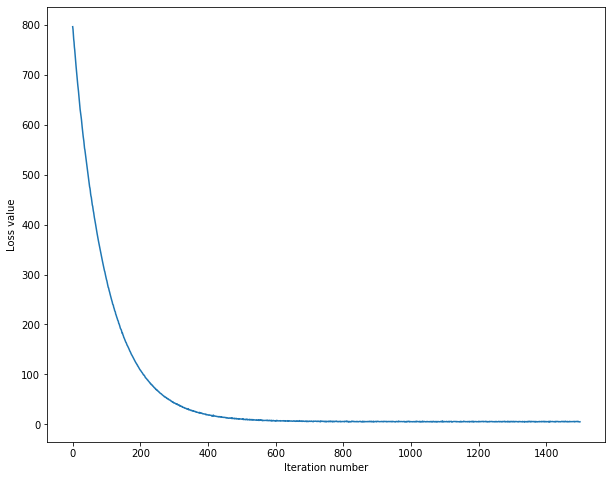

In [486]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [487]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369245
validation accuracy: 0.382000


In [490]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4, 6e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1200, verbose=True)

        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        trainacc = np.mean(y_train == y_train_pred)
        valacc = np.mean(y_val == y_val_pred)
        if valacc > best_val:
            best_val = valacc
            print("Best so far", best_val)
            best_svm = svm
            
        results[(lr, reg)] = (trainacc, valacc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1200: loss 641.537204
iteration 100 / 1200: loss 284.040324
iteration 200 / 1200: loss 129.187537
iteration 300 / 1200: loss 60.843772
iteration 400 / 1200: loss 29.814580
iteration 500 / 1200: loss 15.927551
iteration 600 / 1200: loss 9.816513
iteration 700 / 1200: loss 7.250183
iteration 800 / 1200: loss 6.118514
iteration 900 / 1200: loss 5.884829
iteration 1000 / 1200: loss 5.603761
iteration 1100 / 1200: loss 5.478669
Best so far 0.377
iteration 0 / 1200: loss 784.995644
iteration 100 / 1200: loss 285.977886
iteration 200 / 1200: loss 106.902778
iteration 300 / 1200: loss 41.697865
iteration 400 / 1200: loss 18.589987
iteration 500 / 1200: loss 9.806438
iteration 600 / 1200: loss 6.737168
iteration 700 / 1200: loss 5.701614
iteration 800 / 1200: loss 5.614721
iteration 900 / 1200: loss 5.129614
iteration 1000 / 1200: loss 4.815468
iteration 1100 / 1200: loss 5.439261
iteration 0 / 1200: loss 941.765647
iteration 100 / 1200: loss 282.132897
iteration 200 / 1200: loss 

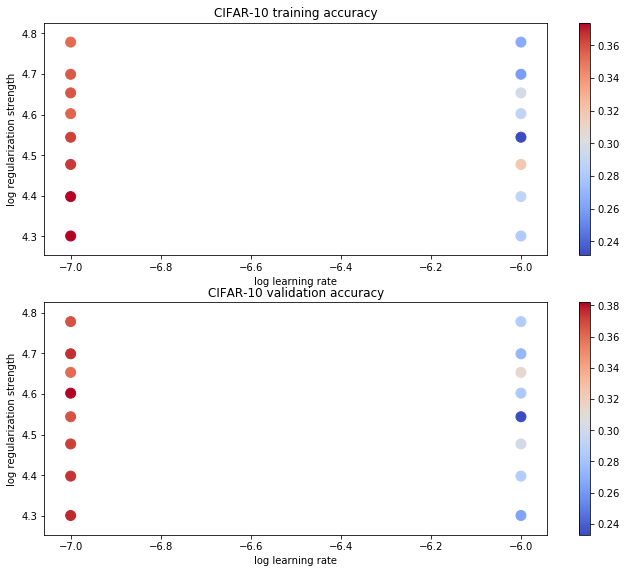

In [491]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [492]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.348000


In [499]:
best_svm.W[:-1,:][0]

array([-5.29332301e-06,  2.76118404e-06, -2.00798832e-06,  1.14789272e-05,
       -2.91880195e-05, -2.29848958e-05,  2.01578470e-05, -1.73800548e-06,
        9.66470629e-06,  1.72255492e-05])

In [510]:
w[:,:,1,0]

array([[-2.89698551e-06, -6.97477272e-06, -9.17867261e-06, ...,
        -7.77236906e-06, -8.47094568e-06, -4.39498237e-06],
       [-3.54845029e-06, -8.85382051e-06, -1.02312927e-05, ...,
        -7.78820976e-06, -7.24162089e-06, -1.57749257e-06],
       [-5.06196948e-06, -1.10062376e-05, -1.26560969e-05, ...,
        -9.46046031e-06, -8.62660871e-06, -1.50920773e-06],
       ...,
       [-2.98903127e-05, -2.24762485e-05, -1.39221564e-05, ...,
        -2.28057489e-05, -2.64534123e-05, -2.72821157e-05],
       [-2.83479577e-05, -2.31225127e-05, -1.56113384e-05, ...,
        -2.71129869e-05, -3.10380038e-05, -3.10603071e-05],
       [-3.06143844e-05, -2.64157315e-05, -2.18168675e-05, ...,
        -3.01444950e-05, -3.49774424e-05, -3.42615211e-05]])

In [531]:
X_train_1, y_train_1, X_test_1, y_test_1 = load_CIFAR10(cifar10_dir)


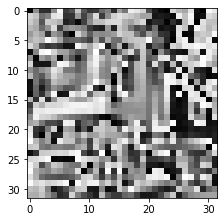

In [572]:
plt.rcParams['figure.figsize'] = (6.0, 3.5) # set default size of plots
plt.imshow(X_train_1[1][:,:,0].astype('uint8') + X_train_1[1][:,:,1].astype('uint8') + X_train_1[1][:,:,1].astype('uint8'))

In [607]:
conc = np.concatenate((X_train_1[1][:,:,0].astype('uint8'), X_train_1[1][:,:,1].astype('uint8'), X_train_1[1][:,:,2].astype('uint8')),1)

In [611]:
conc.reshape((32,32,3), order="F")

array([[[154, 177, 187],
        [126, 137, 136],
        [105, 104,  95],
        ...,
        [ 91,  95,  71],
        [ 87,  90,  71],
        [ 79,  81,  70]],

       [[140, 160, 169],
        [145, 153, 154],
        [125, 125, 118],
        ...,
        [ 96,  99,  78],
        [ 77,  80,  62],
        [ 71,  73,  61]],

       [[140, 155, 164],
        [139, 146, 149],
        [115, 115, 112],
        ...,
        [ 79,  82,  64],
        [ 68,  70,  55],
        [ 67,  69,  55]],

       ...,

       [[175, 167, 166],
        [156, 154, 160],
        [154, 160, 170],
        ...,
        [ 42,  34,  36],
        [ 61,  53,  57],
        [ 93,  83,  91]],

       [[165, 154, 128],
        [156, 152, 130],
        [159, 161, 142],
        ...,
        [103,  93,  96],
        [123, 114, 120],
        [131, 121, 131]],

       [[163, 148, 120],
        [158, 148, 122],
        [163, 156, 133],
        ...,
        [143, 133, 139],
        [143, 134, 142],
        [143, 133, 144]]

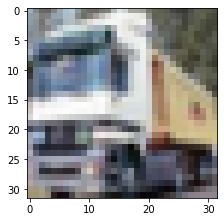

In [613]:
plt.imshow(conc.reshape((32,32,3), order="F"))

In [618]:
w.shape

(32, 32, 3, 10)

In [520]:
plt.imshow(w[:,:,1,0] +  w[:,:,2,0] + +  w[:,:,3,0])

IndexError: index 3 is out of bounds for axis 2 with size 3

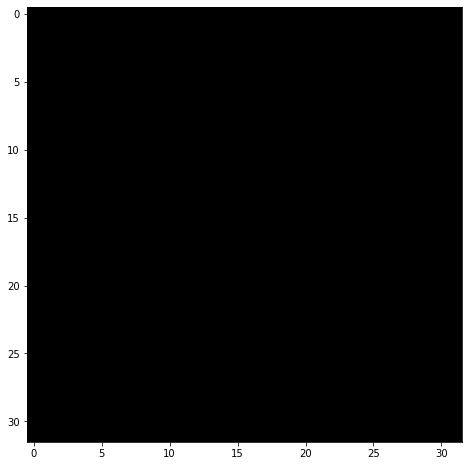

In [512]:
plt.imshow(w[:,:,2,0].astype('uint8'))

(3072, 10)


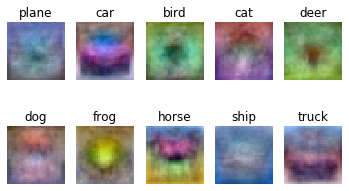

In [621]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
print(best_svm.W[:-1,:].shape)
w = best_svm.W[:-1,:] # strip out the bias (bias is last pixel X_test[:,-1])
w = w.reshape(32, 32, 3, 10, order="C")
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
